In [0]:
pip install scikit-optimize

     |████████████████████████████████| 81kB 5.1MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


In [0]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


In [0]:
gc.enable()

train = pd.read_csv('/data/plasticc_train_lightcurves.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected_bool': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train
gc.collect()


120

In [0]:
meta_train = pd.read_csv('/data/plasticc_train_metadata.csv')
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)


Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [0]:
y.head()

0    92
1    88
2    42
3    90
4    90
Name: target, dtype: int64

In [0]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [0]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)



In [0]:


y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]



In [0]:
w = dict(zip(unique_y,wtable))
w

{6: 0.019240570846075434,
 15: 0.06307339449541284,
 16: 0.11773700305810397,
 42: 0.152013251783894,
 52: 0.023318042813455658,
 53: 0.00382262996941896,
 62: 0.06167176350662589,
 64: 0.012996941896024464,
 65: 0.125,
 67: 0.026503567787971458,
 88: 0.047145769622833844,
 90: 0.2947247706422018,
 92: 0.03045361875637105,
 95: 0.0222986748216106}

In [0]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()

In [0]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',name='learning_rate')
dim_estimators = Integer(low=50, high=2000,name='n_estimators')
dim_max_depth = Integer(low=1, high=6,name='max_depth')

dimensions = [dim_learning_rate,
              dim_estimators,
              dim_max_depth]

default_parameters = [0.03,1000,3]

In [0]:

def createModel(learning_rate,n_estimators,max_depth):       

    oof_preds = np.zeros((len(full_train), len(classes)))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('fold',fold_+1,multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        clfs.append(clf)
    
    loss = multi_weighted_logloss(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % loss)
    
    return loss

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,n_estimators,max_depth):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    n_estimators:      Number of estimators.
    max_depth:         Maximum Depth of tree.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.2e}'.format(learning_rate))
    print('estimators:', n_estimators)
    print('max depth:', max_depth)
    
    lv= createModel(learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth = max_depth)
    return lv


In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'subsample': .9,
    'colsample_bytree': .7,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'silent':True,
    'verbosity':-1,
    'nthread':-1
}

In [0]:
%%time
error = fitness(default_parameters)

learning rate: 3.00e-02
estimators: 1000
max depth: 3
fold 1 0.04552937931632866
fold 2 0.05269964802881655
fold 3 0.04494923965280621
fold 4 0.029618031036433786
fold 5 0.04108295363539339
MULTI WEIGHTED LOG LOSS : 0.04280 
CPU times: user 10min 29s, sys: 3.07 s, total: 10min 32s
Wall time: 10min


In [0]:
%%time
# use only if you haven't found out the optimal parameters for xgb. else comment this block.
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=20,
                           x0=default_parameters)

learning rate: 3.00e-02
estimators: 1000
max depth: 3
fold 1 0.04552937931632866
fold 2 0.05269964802881655
fold 3 0.04494923965280621
fold 4 0.029618031036433786
fold 5 0.04108295363539339
MULTI WEIGHTED LOG LOSS : 0.04280 
learning rate: 4.68e-05
estimators: 1911
max depth: 3
fold 1 2.747782594519442
fold 2 2.736776974109028
fold 3 2.7386983038070665
fold 4 2.738267929342935
fold 5 2.7390960994878952
MULTI WEIGHTED LOG LOSS : 2.74019 
learning rate: 2.31e-02
estimators: 428
max depth: 2
fold 1 0.04754491007375734
fold 2 0.05328002150060965
fold 3 0.04254761142223219
fold 4 0.029610290071778213
fold 5 0.03890547377412837
MULTI WEIGHTED LOG LOSS : 0.04241 
learning rate: 7.68e-02
estimators: 1703
max depth: 5
fold 1 0.04246348750389313
fold 2 0.05425669651042328
fold 3 0.042772634952508604
fold 4 0.029821183681131253
fold 5 0.04066881351984229
MULTI WEIGHTED LOG LOSS : 0.04200 
learning rate: 1.42e-04
estimators: 1147
max depth: 4
fold 1 2.437411048915449
fold 2 2.4189899175866394
fold

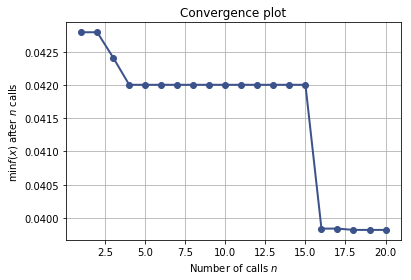

In [0]:
plot_convergence(search_result)
plt.show()

In [0]:
# optimal parameters found using scikit optimize. use these parameter to initialize the 2nd level model.
print(search_result.x)
learning_rate = search_result.x[0]
n_estimators = search_result.x[1]
max_depth = search_result.x[2]



[0.018586702823263707, 1211, 1]


In [0]:


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()



Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.758625	training's wloss: 1.19518	valid_1's multi_logloss: 0.761592	valid_1's wloss: 1.21599
[200]	training's multi_logloss: 0.34466	training's wloss: 0.56402	valid_1's multi_logloss: 0.348022	valid_1's wloss: 0.585537
[300]	training's multi_logloss: 0.168771	training's wloss: 0.283653	valid_1's multi_logloss: 0.17213	valid_1's wloss: 0.305201
[400]	training's multi_logloss: 0.0866064	training's wloss: 0.154188	valid_1's multi_logloss: 0.089877	valid_1's wloss: 0.174287
[500]	training's multi_logloss: 0.0486939	training's wloss: 0.0925165	valid_1's multi_logloss: 0.0521309	valid_1's wloss: 0.11139
[600]	training's multi_logloss: 0.0299304	training's wloss: 0.0613033	valid_1's multi_logloss: 0.0332693	valid_1's wloss: 0.0780105
[700]	training's multi_logloss: 0.0201131	training's wloss: 0.0447935	valid_1's multi_logloss: 0.023071	valid_1's wloss: 0.0594543
[800]	training's multi_logloss: 0.015

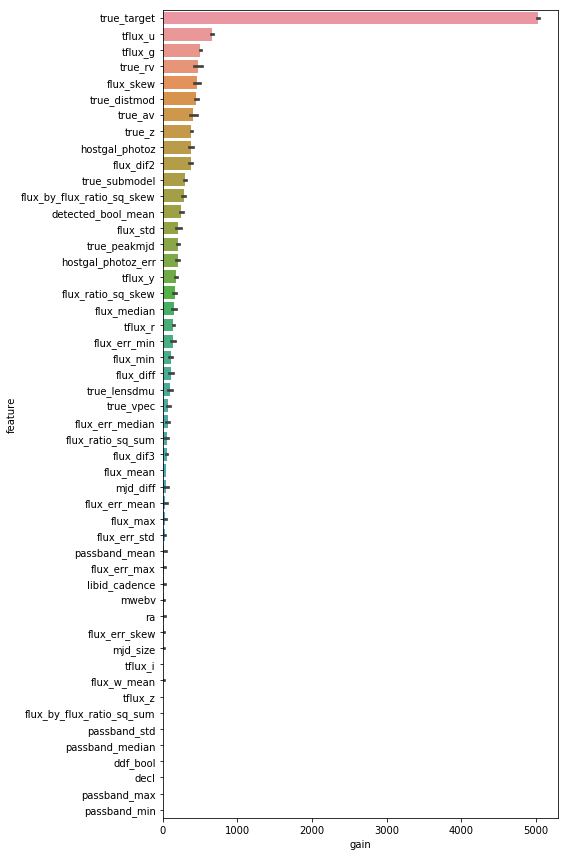

In [0]:
oof_preds = np.zeros((len(full_train), len(classes)))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]
    
    clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain', y='feature', data=importances.sort_values('mean_gain', ascending=False))
plt.tight_layout()
plt.savefig('importances.png')


In [0]:
print(oof_preds.shape)
oof_preds

(7848, 14)


array([[1.05309254e-04, 1.91291357e-06, 8.84152877e-04, ...,
        2.49121421e-03, 9.89192364e-01, 7.24517747e-06],
       [2.04816699e-04, 7.42446245e-05, 1.44985121e-03, ...,
        9.20538345e-05, 9.51850884e-05, 1.48180686e-03],
       [7.21057147e-05, 4.80709778e-05, 2.79018111e-05, ...,
        5.91704814e-04, 5.27991751e-05, 6.73491548e-05],
       ...,
       [7.18430640e-04, 1.34684354e-05, 9.93804070e-01, ...,
        1.31273851e-05, 6.72030223e-04, 3.43024488e-05],
       [1.75102168e-04, 5.77892735e-05, 2.45891439e-04, ...,
        2.23579405e-04, 1.66787500e-04, 1.40633442e-04],
       [9.79539049e-01, 6.64195506e-03, 1.15715000e-02, ...,
        4.18305416e-06, 1.35480702e-04, 4.88630149e-06]])

In [0]:
meta_test = pd.read_csv('/content/drive/My Drive/data/plasticc_test_metadata.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('/content/drive/My Drive/data/plasticc_test_lightcurves_02.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test = full_test.fillna(train_mean)
    
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test[full_train.columns]) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test[full_train.columns]) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=['class_' + str(s) for s in clfs[0].classes_])
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)
    
        
    del agg_test,preds
    gc.collect()
    
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))


In [0]:


z = pd.read_csv('predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions.csv', index=True)



2
8


In [0]:
print(z.shape)
z

(345997, 15)


,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
1000183,0.000050,0.000037,0.000123,0.000273,0.000301,0.000031,0.000420,0.000105,0.000150,0.001493,0.002705,0.993935,0.000040,0.000334,0.074071
1000235,0.000167,0.000002,0.000219,0.000002,0.000007,0.000205,0.000014,0.000012,0.002885,0.000024,0.003298,0.002118,0.991039,0.000008,0.109130
1000260,0.000077,0.000055,0.000035,0.995088,0.001185,0.000070,0.002010,0.000019,0.000074,0.000275,0.000181,0.000596,0.000054,0.000283,0.060063
1000280,0.000035,0.000028,0.000021,0.000214,0.000258,0.000023,0.000299,0.000101,0.000354,0.001201,0.001619,0.995559,0.000028,0.000261,0.054330
1000282,0.000906,0.000400,0.002043,0.000477,0.000979,0.000452,0.001655,0.000943,0.001321,0.003079,0.982228,0.000478,0.000570,0.004469,0.214523
1000345,0.000036,0.000030,0.000021,0.000241,0.000287,0.000023,0.000336,0.000064,0.000095,0.001025,0.001888,0.995657,0.000028,0.000270,0.053137
1000388,0.000068,0.000050,0.000026,0.995798,0.001246,0.000062,0.001823,0.000014,0.000021,0.000357,0.000053,0.000373,0.000048,0.000062,0.051413
1000483,0.000032,0.000027,0.000013,0.000192,0.000212,0.000020,0.000250,0.000060,0.000115,0.002371,0.000403,0.996249,0.000025,0.000031,0.045916
1000490,0.000035,0.000026,0.000020,0.000192,0.000201,0.000024,0.000323,0.000231,0.000412,0.001262,0.001856,0.995126,0.000027,0.000264,0.059596


In [0]:
y_t = full_test['true_target']
print(y_t.shape)
print(y_t.values)
y_t



(33476,)
[42 90 90 ... 90 42 42]


0         42
1         90
2         90
3         92
4         52
5         90
6         90
7         90
8         92
9         90
10        42
11        90
12        90
13        90
14       993
15        62
16        92
17        90
18        42
19        90
20        62
21        90
22        42
23        42
24        90
25        62
26        42
27        42
28        95
29        90
        ... 
33446     42
33447     62
33448     62
33449     42
33450     65
33451     42
33452     42
33453     90
33454     42
33455     42
33456     42
33457     42
33458     90
33459     90
33460     42
33461     90
33462     90
33463     16
33464     90
33465     92
33466     42
33467     42
33468     90
33469     90
33470     90
33471     90
33472     42
33473     90
33474     42
33475     42
Name: true_target, Length: 33476, dtype: int64

In [0]:
y_t = y_t.replace([991,992,993,994,995],99)
y_t
        

0        42
1        90
2        90
3        92
4        52
5        90
6        90
7        90
8        92
9        90
10       42
11       90
12       90
13       90
14       99
15       62
16       92
17       90
18       42
19       90
20       62
21       90
22       42
23       42
24       90
25       62
26       42
27       42
28       95
29       90
         ..
33446    42
33447    62
33448    62
33449    42
33450    65
33451    42
33452    42
33453    90
33454    42
33455    42
33456    42
33457    42
33458    90
33459    90
33460    42
33461    90
33462    90
33463    16
33464    90
33465    92
33466    42
33467    42
33468    90
33469    90
33470    90
33471    90
33472    42
33473    90
33474    42
33475    42
Name: true_target, Length: 33476, dtype: int64

In [0]:
#preds_df = preds_df.drop(columns='object_id')
preds_df

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000177,0.000150,0.000321,0.987345,0.007286,0.000200,0.001591,0.000019,0.000038,0.000407,0.000693,0.000911,0.000141,0.000722,0.152791
1,0.000035,0.000027,0.000018,0.000235,0.000281,0.000023,0.000355,0.000064,0.000270,0.001231,0.001607,0.995612,0.000028,0.000215,0.053426
2,0.000036,0.000028,0.000014,0.000178,0.000209,0.000023,0.000325,0.000053,0.000129,0.002080,0.000335,0.996531,0.000027,0.000033,0.042277
3,0.000121,0.000001,0.000302,0.000001,0.000005,0.000096,0.000012,0.000011,0.002803,0.000059,0.002309,0.004277,0.989995,0.000007,0.121125
4,0.002103,0.001430,0.000876,0.009609,0.941828,0.002446,0.020361,0.000318,0.000489,0.009855,0.001323,0.005655,0.001626,0.002081,0.670894
5,0.000033,0.000028,0.000014,0.000200,0.000204,0.000022,0.000288,0.000056,0.000198,0.001897,0.000410,0.996587,0.000026,0.000036,0.041587
6,0.000038,0.000031,0.000037,0.000149,0.000259,0.000025,0.000337,0.000152,0.000342,0.001197,0.001687,0.995469,0.000030,0.000246,0.055155
7,0.000036,0.000026,0.000030,0.000193,0.000185,0.000022,0.000325,0.000141,0.000216,0.001175,0.001612,0.995748,0.000028,0.000262,0.051778
8,0.000102,0.000001,0.000198,0.000001,0.000004,0.001066,0.000009,0.000009,0.002382,0.000018,0.002472,0.001576,0.992158,0.000004,0.095137
9,0.000057,0.000032,0.000070,0.000184,0.000214,0.000033,0.000323,0.000230,0.000394,0.001857,0.000648,0.995864,0.000047,0.000046,0.050369


In [0]:
p = np.array(preds_df)
print(p.shape)
p

(33476, 15)


array([[1.77459699e-04, 1.49726660e-04, 3.21005100e-04, ...,
        1.41203314e-04, 7.22082610e-04, 1.52791467e-01],
       [3.54164084e-05, 2.65958616e-05, 1.78730057e-05, ...,
        2.75474400e-05, 2.15357507e-04, 5.34260211e-02],
       [3.56941081e-05, 2.78375352e-05, 1.37010185e-05, ...,
        2.70206450e-05, 3.25937682e-05, 4.22771893e-02],
       ...,
       [5.32389933e-05, 3.26108899e-05, 2.26568836e-05, ...,
        3.58079666e-05, 9.01468393e-05, 4.15655993e-02],
       [8.27609240e-05, 5.88429690e-05, 1.32984330e-04, ...,
        5.90630469e-05, 1.28630646e-04, 6.30053290e-02],
       [2.16246916e-04, 1.79049330e-04, 3.85731178e-04, ...,
        1.82303413e-04, 1.59320914e-03, 1.75225020e-01]])

In [0]:
print(lgb_multi_weighted_logloss(y_t,p))
print(multi_weighted_logloss(y_t,p))

('wloss', 0.059011752351323214, False)
0.059011752351323214


In [0]:
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
if len(np.unique(y_t)) > 14:
    classes.append(99)
    class_weight[99] = 2
y_p = p
# Trasform y_true in dummies
y_ohe = pd.get_dummies(y_t)
# Normalize rows and limit y_preds to 1e-15, 1-1e-15
    

In [0]:
print(classes)
print(y_ohe)

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95, 99]
       6   15  16  42  52  53  62  64  65  67  88  90  92  95  99
0       0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
1       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
2       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3       0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
4       0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
5       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
6       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
7       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
8       0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
9       0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
10      0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
11      0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
12      0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
13      0   0   